In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_long"): print("\nThe data folder \"_data_long\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_long/"); 
    path_data = path_notebook + "/_data_long/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_long/


## Analytical surface

The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -8.4  pl_xmax= 8.4  pl_nx= 701


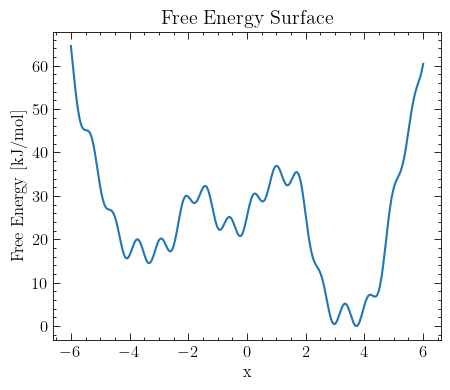

In [2]:
# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 50, 50, 50, 70, 60, 60, 70, 80, 80, 90, 80, 90, 80, 100, 100, 100, 110, 110]
    n_surf = 3
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, print_info=True)
    plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

### Example simulation

In [4]:
# Stimulation path
path_simulation = path_data + "test/"

# Select surface
n_surf = 3
y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]

# Set default parameters
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 2_000_000, 
					"position_pace":50, "metad_pace":500, "n_pos_per_window":10, "metad_width":0.1, "metad_height":5, "biasfactor":50 , 
                    "len_error_list":100, "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":True, "bootstrap_iter":50, 
                    "save_results":True, "save_mfi_instance":True, "simulation_folder_path": path_simulation, "print_info": True}

Simulation started with Terminal input: plumed pesmd < input >/dev/null 2>&1

Running Langevin dynamics: n_steps=2,000,000, ipos=-3.228, Pos_t=50, T=1, t_Tot=10.00ns
sigma=0.1, h=5, bf=50, Gaus_t=500
Static bias used: None 

| 100% | Simulated time: 10.0002ns | Total time: 21 sec | Finished at 19:34:59                                                         

Langevin simulation finished in 21 sec.
| 100% | AAD: 0.159 [kJ/mol] | Total time: 4 sec                                                            


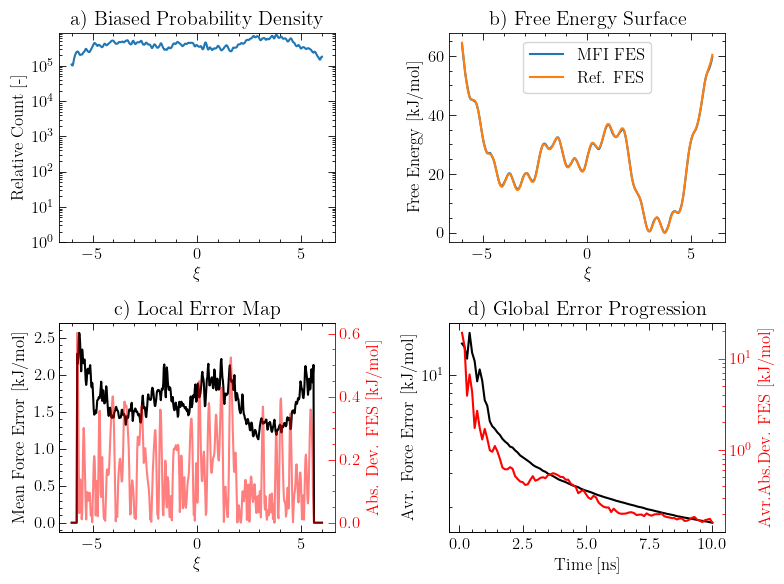

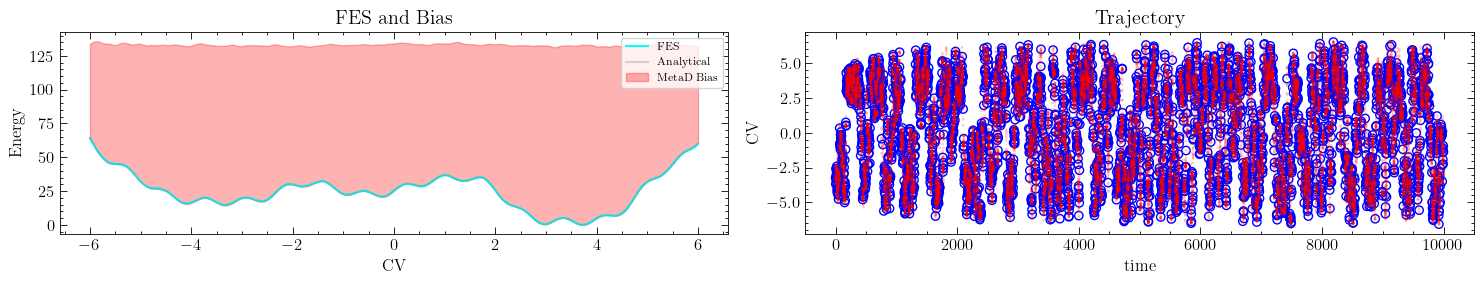

In [5]:
## Load MFI object
MFI = MFI_class1D.MFI1D(**default_params)

## Run the simulation
MFI.run_simulation()

## Analyse the data
MFI.analyse_data()

## Plot the results and save the data for later use
MFI.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI.grid, fes=MFI.FES, metad_bias=MFI.Bias, position=MFI.position, hills=MFI.hills, y=MFI.y )

## Alanine Dipeptide

In [8]:
grid = np.linspace(-np.pi, np.pi, 101); 
[pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, periodic=True, print_info=True)

path_AP = path_data + "Alanine_Dipeptide/"
path_input = path_notebook + "/gmx_files/Alanine_Dipeptide/"
plumed_dat_text = f"MOLINFO STRUCTURE={path_input}reference.pdb\nphi: TORSION ATOMS=@phi-2\n"


In [10]:
# default parameters for the MFI class
default_params = {	"grid":grid, #"Z":AP_ref, 
                    "pl_grid":pl_x, "periodic":True, "System":"gromacs", "cv_name":"phi", "plumed_dat_text":plumed_dat_text,
                    "kT":2.49, "time_step":0.001, "simulation_steps":1_000_000, "position_pace":10, "n_pos_per_window":10, 
					"metad_pace":100, "metad_width":0.1, "metad_height":10, "biasfactor":10, "bw":0.1,
         			"len_error_list":100, "FES_cutoff":80.0, # "record_maps":True, "record_forces_e":True, "calculate_FES_st_dev":True, "bootstrap_iter":50,
                    # "save_error_progression":True, "save_force_terms":True, "save_results":True, "save_mfi_instance":True, 
                    "simulation_folder_path": path_AP+"test/", "ID":"",
				  	
                    "find_sim_init_structure":True, "make_tpr_input_file":True, 
					"trajectory_xtc_file_path_list":[path_input+"traj_0.xtc"], "structure_gro_file_path":path_input+"structure.gro", "mdp_file_path":path_input+"gromppvac.mdp", "top_file_path":path_input+"topology.top", "tpr_file_path":path_input+"input.tpr", "pdb_file_path":path_input+"reference.pdb",
           			}
                  

Simulation started with Terminal input: gmx mdrun -s input_new.tpr -nsteps 100000 -plumed plumed.dat >/dev/null 2>&1

Running Langevin dynamics: n_steps=100,000, ipos=-2.721, Pos_t=10, T=2.49, t_Tot=0.10ns
sigma=0.1, h=10, bf=10, Gaus_t=100
Static bias used: None 

| 100% | Simulated time: 0.1ns | Total time: 21 sec | Finished at 19:37:00                                                         

gromacs simulation finished in 21 sec.
| 100% | ST ERR: 2.89 [kJ/mol] | Total time: 0 sec                                                            


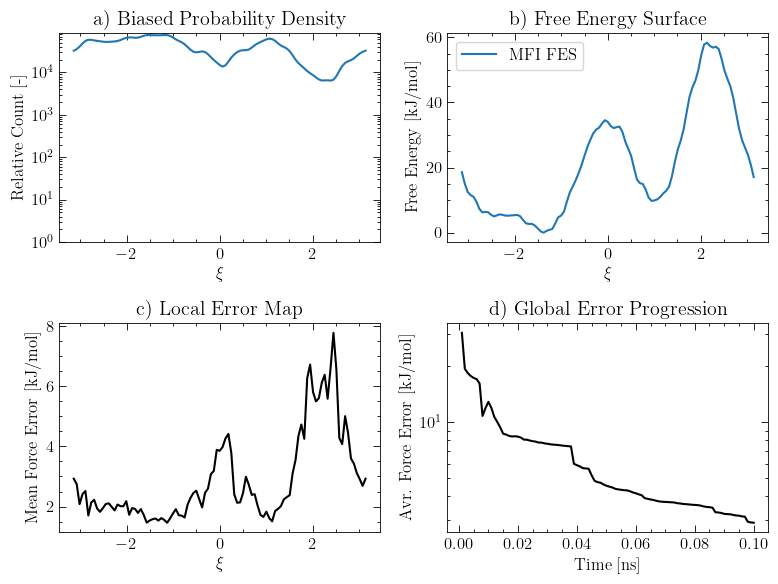

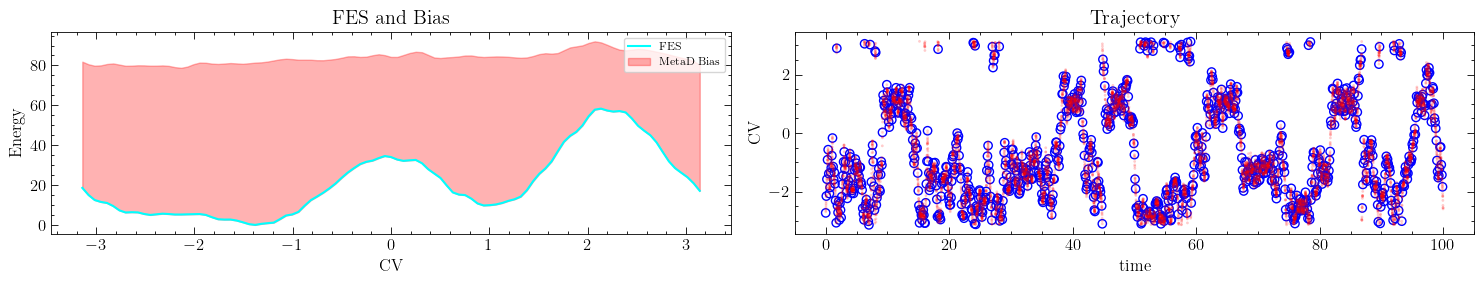

In [11]:

new_params = {**default_params}
new_params.update({"ID":"_test", "simulation_folder_path": path_AP})
# new_params.update({"position_pace":20, "metad_pace":200})

## Load MFI object
MFI = MFI_class1D.MFI1D(**new_params)

## Run the simulation
MFI.run_simulation()

## Analyse the data
MFI.analyse_data()

## Plot the results and save the data for later use
MFI.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI.grid, fes=MFI.FES, metad_bias=MFI.Bias, position=MFI.position, hills=MFI.hills, y=MFI.y )


## Run Multiple Long Simulations and analysis (for statistical analysis)

In [12]:
# Set default parameters
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 20_000_000, 
					"position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":5, "biasfactor":50 , 
					"len_error_list":100, "FES_cutoff":FES_cutoff, 
                    "save_error_progression": True, "save_force_terms": True, 
     				"simulation_folder_path": path_data+"test/", "print_info": True}

In [6]:
# list from 0 to 19 except 4, 6, 12, 17
n_surf_list = [0, 1, 2, 3, 8, 16]

# Loop over all surfaces
for n_surf in n_surf_list:
    y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    print(f"\n~~~~~~ Surface {n_surf} ~~~~~~")

    # loop over simulations
    n_sim = 16 if n_surf != 3 else 24    
    for i in range(1,n_sim):
        
        print(f"~~~~~~ Simulation {i} ~~~~~~")
        
        sim_id = f"_{i}_100ns"
        new_path = path_data + f"S{n_surf}/simulation{sim_id}/"
        
        #check if directory exists
        if os.path.isdir(new_path): pass
        else: os.mkdir(new_path)
        os.chdir(new_path)
        
        new_params = default_params.copy()
        new_params.update({"simulation_folder_path":new_path, "ID":sim_id})
        new_params.update({"y":y, "plumed_dat_text":plumed_dat_text, "FES_cutoff":FES_cutoff})

        ## Load MFI object
        MFI = MFI_class1D.MFI1D(**new_params)

        ## check if HILLS file exists
        if os.path.isfile(MFI.hills_file): print("HILLS file exists, skipping simulation")
        else: MFI.run_simulation()
            
        if os.path.isfile(f"error_progression{sim_id}.pkl"): print("Data file exists, skipping analysis")
        else:
            MFI.analyse_data()
            # MFI.plot_results()
            
            print(f"\n\n{MFI.AAD = }\n\n")
            
        



~~~~~~ Surface 0 ~~~~~~
~~~~~~ Simulation 1 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 2 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 3 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 4 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 5 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 6 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 7 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 8 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 9 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 10 ~~~~~~
HILLS file exists, skipping s

### Get Mean and ST ERR of Error Progression

t=[1.00,100.00] | Final avr: AOFE=0.528, AAD=0.070


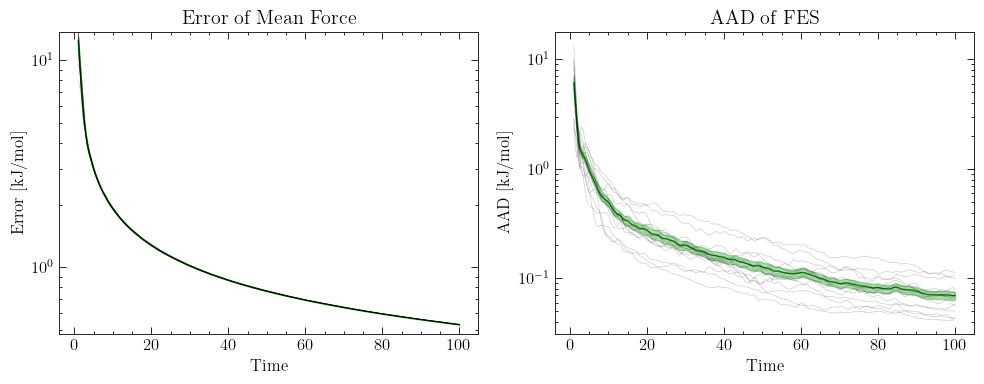

In [5]:
n_surf = 13
total_campaigns = 14
time_budget = 100

lib1.get_avr_error_prog(path_data, n_surf=n_surf, total_campaigns=total_campaigns, time_budget=time_budget, simulation_type="long", show_plot=True)

